init factory
The use of parenthesis for accessing tasks is deprecated, use brackets instead.
be= 4
fe= 1
The use of parenthesis for accessing tasks is deprecated, use brackets instead.


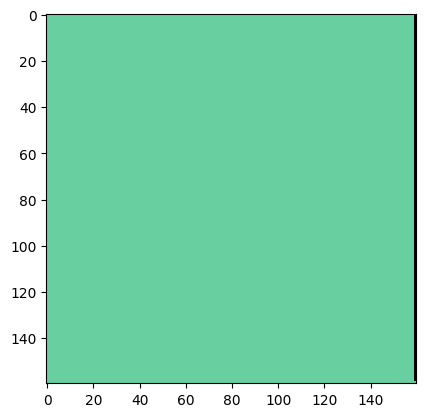

In [1]:
#!/usr/bin/env python3

import numpy as np
import random 
import math
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../pyaf/py_aff3ct/build/lib')
sys.path.insert(0, '../pyaf/build/lib')

import pyaf
import py_aff3ct as aff3ct
from py_aff3ct.module.py_module import Py_Module

from conductor           import conductor
from add_impulses     import add_impulses
from factory          import factory
from display_impulses import display_impulses

code_type = "polar"
if(code_type == "turbo"):
	K = 64*2
	N = 3*K
elif(code_type == "ldpc"):
	N = 576 
	K = 288
elif(code_type == "polar"):
	N = 128
	K = 64
elif(code_type == "bch"):
	N = 127
	K = 106
else:
	print("Error : code type is not supported.")
	exit()
	
ebn0 = np.asarray([2.8])
I = 8
load_file = False

delta_x_range = np.arange(-4,4,0.05)
delta_y_range = np.arange(-4,4,0.05)

W = len(delta_x_range)
H = len(delta_y_range)

fac = factory(code_type, N, K, ebn0, I)

enc, dec = fac.build()
sigma_val = fac.sigma_val

src  = aff3ct.module.source.Source_random_fast(K, 12)
mdm  = aff3ct.module.modem.Modem_BPSK_fast(N)

gen = aff3ct.tools.Gaussian_noise_generator_implem.FAST
chn = aff3ct.module.channel.Channel_AWGN_LLR(N, gen)
mnt = aff3ct.module.monitor.Monitor_BFER_AR(K, 1)

sigma      = np.ndarray(shape = (1,1),  dtype = np.float32)
noisy_vec  = np.ndarray(shape = (1,N),  dtype = np.float32)
vec_src    = np.ndarray(shape = (1,K),  dtype = np.int32)
r_in       = np.ndarray(shape = (1,N),  dtype = np.float32)

map = np.zeros( (H,W,3), dtype=np.uint8)
src.reset()

seed = random.randint(0, 123456789)
src.set_seed(seed+1)
chn.set_seed(seed)

src["generate   ::U_K  "] = enc["encode       ::U_K "]
enc["encode     ::X_N  "] = mdm["modulate     ::X_N1"]
mdm["modulate   ::X_N2 "] = chn["add_noise    ::X_N "]
chn["add_noise  ::Y_N  "] = mdm["demodulate   ::Y_N1"]
mdm["demodulate ::Y_N2 "] = dec["decode_siho  ::Y_N "]
src["generate   ::U_K  "] = mnt["check_errors ::U   "]
dec["decode_siho::V_K  "] = mnt["check_errors ::V   "]
chn["add_noise  ::CP   "].bind( sigma  )
mdm["demodulate ::CP   "].bind( sigma  )

seq1 = aff3ct.tools.sequence.Sequence(src("generate"),  1)
seq1.export_dot("chaos.dot")

if(load_file == False):
	for i in range(len(sigma_val)):
		sigma[:] = sigma_val[i]
		seq1.exec()		
		print("be=",mnt.get_n_be())
		print("fe=",mnt.get_n_fe())
		mnt.reset()
	with open('noisy_cw.npy', 'wb') as f:
		np.save(f, dec['decode_siho::Y_N'][:])
		np.save(f, src['generate::U_K'][:])
with open('noisy_cw.npy', 'rb') as f:
	r_in = np.load(f)
	vec_src = np.load(f)

# Pour le module conductor
ix_x    = np.ndarray(shape = (1,1),  dtype = np.int32  )
ix_y    = np.ndarray(shape = (1,1),  dtype = np.int32  )
ix_x[:] = 1  # np.random.randint(N)
ix_y[:] = 20 # (ix_x[:]+5) % N 

# Pour le module display
heat_map = np.ndarray(shape=(5,3),dtype = np.uint8)
heat_map[0] = [4,8,16]
heat_map[1] = [16,8,4]
heat_map[2] = [8,16,4]
heat_map[3] = [100,50,25]
heat_map[4] = [16,16,16]
h_ix = 0

cdc    = pyaf.conductor.Conductor(noisy_vec[0,:], N, ix_x, ix_y) # Conductor
adi    = add_impulses(N)
enc, dec2   = fac.build()
mnt2   = aff3ct.module.monitor.Monitor_BFER(K, 1)
dis    = display_impulses(H, W, heat_map, h_ix)

cdc   ["generate :: noisy_vec" ] = adi   ["add :: r_in   "     ] 
cdc   ["generate :: enable "   ] = adi   ["add :: enable "     ]   
cdc   ["generate :: delta_x"   ] = adi   ["add :: delta_x"     ]
cdc   ["generate :: delta_y"   ] = adi   ["add :: delta_y"     ]
cdc   ["generate :: ix_x   "   ] = adi   ["add :: ix_x   "     ]
cdc   ["generate :: ix_y   "   ] = adi   ["add :: ix_y   "     ]
adi   ["add           :: r_out"] = dec2  ["decode_siho  ::Y_N" ]
dec2  ["decode_siho   :: V_K  "] = mnt2  ["check_errors2::V"   ]
dis   ["display :: x"          ] = cdc   ["generate :: x"      ]
dis   ["display :: y"          ] = cdc   ["generate :: y"      ]
dis   ["display :: BE "        ] = mnt2  ["check_errors2 :: BE"]
dis   ["display :: enable"     ] = cdc   ["generate :: enable" ] 

mnt2  ["check_errors2:: U"].bind(vec_src)
mnt2.create_reset_task()
mnt2  ["reset" ] = dis["display::status"]

seq2 = aff3ct.tools.sequence.Sequence(cdc   ("generate"),  1)
seq2.export_dot("full_module.dot")

seq2.exec()
plt.imshow(dis.map, interpolation='none')
plt.show()

## Il semblerait qu'il y ai un offset de -1 selon x